In [1]:
import pandas as pd
import sunpy.data.sample
import sunpy.map

from astropy.coordinates import SkyCoord
from astropy import units as u 
from sunpy.coordinates import frames, get_horizons_coord
import astrospice
import urllib
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy
import glob

In [2]:
stix_flares = pd.read_csv("/Users/laura.hayes/flare_ana/stix_flarelists/STIX_flarelist_w_locations_20210214_20230901_version1.csv")

kernals = astrospice.registry.get_kernels("solar orbiter", "predict")
solo_coords_full = astrospice.generate_coords("SOLAR ORBITER", pd.to_datetime(stix_flares["peak_UTC"])).heliographic_stonyhurst
earth_coords_full = astrospice.generate_coords("earth", pd.to_datetime(stix_flares["peak_UTC"])).heliographic_stonyhurst

flare_coords_solo_hpc = SkyCoord(stix_flares["hpc_x_solo"].values*u.arcsec, 
                                 stix_flares["hpc_y_solo"].values*u.arcsec, 
                                 frame=frames.Helioprojective(observer=solo_coords_full))

with frames.Helioprojective.assume_spherical_screen(flare_coords_solo_hpc.observer, only_off_disk=True):
    flare_coords_earth_hpc = flare_coords_solo_hpc.transform_to(frames.Helioprojective(observer=earth_coords_full))
    flare_coords_hgs = flare_coords_solo_hpc.transform_to(frames.HeliographicStonyhurst)
    flare_coords_hgc = flare_coords_solo_hpc.transform_to(frames.HeliographicCarrington)

/Users/laura.hayes/opt/miniconda3/envs/stixflarelist/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

# FERMI flare list

In [3]:
def get_fermi_flare_list():
    url = "https://hesperia.gsfc.nasa.gov/fermi/gbm/qlook/fermi_gbm_flare_list.txt"
    urllib.request.urlretrieve(url, url.split("/")[-1])

In [4]:
get_fermi_flare_list()

In [5]:
fermi_flares_all = pd.read_csv("fermi_gbm_flare_list.txt", skiprows=8, skipfooter=35, 
                 encoding = "ISO-8859-1", delim_whitespace=True, engine="python",
                 usecols=[0,1,2,3,4,5,6, 7, 8, 9, 10, 11], 
                 names=["flare", "date", "ts", "tp", "te", "dur", "peak counts", 
                        "total_counts", "sun_det0", "sun_det1", "sun_det2", "sun_det3"])

In [6]:
fermi_flares_all["t_start"] = pd.to_datetime(fermi_flares_all["date"] + fermi_flares_all["ts"], format="%d-%b-%Y%H:%M:%S")
fermi_flares_all["t_peak"] = pd.to_datetime(fermi_flares_all["date"] + fermi_flares_all["tp"], format="%d-%b-%Y%H:%M:%S")
fermi_flares_all["t_end"] = pd.to_datetime(fermi_flares_all["date"] + fermi_flares_all["te"], format="%d-%b-%Y%H:%M:%S")
fermi_flares_all.drop(columns=["ts", "tp", "te"], inplace=True)

In [7]:
fermi_flares = fermi_flares_all[(fermi_flares_all["t_start"]>=stix_flares["peak_UTC"].min())&(fermi_flares_all["t_start"]<=stix_flares["peak_UTC"].max())]
fermi_flares.reset_index(inplace=True, drop=True)

In [8]:
fermi_flares.head()

,flare,date,dur,peak counts,total_counts,sun_det0,sun_det1,sun_det2,sun_det3,t_start,t_peak,t_end
0,210226_2358,26-Feb-2021,111,562,14367,n5,n3,n1,n0,2021-02-26 23:58:31,2021-02-26 00:00:22,2021-02-26 00:00:22
1,210227_2358,27-Feb-2021,106,81,944,n5,n1,n3,n0,2021-02-27 23:58:34,2021-02-27 23:58:50,2021-02-27 00:00:20
2,210416_2216,16-Apr-2021,218,14392,1805434,n5,n3,n1,n0,2021-04-16 22:16:16,2021-04-16 22:19:40,2021-04-16 22:19:54
3,210422_0433,22-Apr-2021,70,650,7045,n5,n4,n1,n2,2021-04-22 04:33:23,2021-04-22 04:34:08,2021-04-22 04:34:33
4,210422_0916,22-Apr-2021,426,1875,90525,n5,n4,n1,n3,2021-04-22 09:16:34,2021-04-22 09:20:44,2021-04-22 09:23:40


In [9]:
fermi_flares["peak counts"]

0         562
1          81
2       14392
3         650
4        1875
        ...  
2508    47684
2509     2406
2510     1395
2511    11449
2512     2703
Name: peak counts, Length: 2513, dtype: int64

Text(0, 0.5, 'Number of flares')

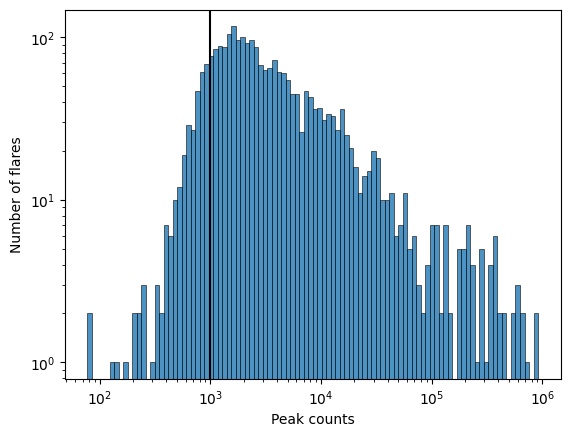

In [10]:
from astropy.visualization import hist
x_gbm = fermi_flares["peak counts"].values
binss='knuth'
n_gbm, linear_bins_gbm, _ = hist(x_gbm, alpha=0.8, edgecolor='k', linewidth=0.5, bins=100, density=True)
plt.close()
logbins_gbm = np.logspace(np.log10(linear_bins_gbm[0]),np.log10(linear_bins_gbm[-1]),len(linear_bins_gbm))

fig, ax = plt.subplots()
nn_gbm, binns_gbm, _ = hist(x_gbm, bins=logbins_gbm, alpha=0.8, edgecolor='k', lw=0.5)
center2_gbm = (binns_gbm[:-1] + binns_gbm[1:]) / 2
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Peak counts")
plt.axvline(1e3, color='k')
ax.set_ylabel("Number of flares")


In [11]:
stix_flares_earth = stix_flares[stix_flares["visible_from_earth"] == True]
stix_flares_earth.reset_index(inplace=True, drop=True)

In [12]:
stix_flares_earth.keys()

Index(['start_UTC', 'end_UTC', 'peak_UTC', '4-10 keV', '10-15 keV',
       '15-25 keV', '25-50 keV', '50-84 keV', 'att_in', 'bkg 4-10 keV',
       'bkg 10-15 keV', 'bkg 15-25 keV', 'bkg 25-50 keV', 'bkg 50-84 keV',
       'bkg_baseline_4-10 keV', 'hpc_x_solo', 'hpc_y_solo', 'hpc_x_earth',
       'hpc_y_earth', 'visible_from_earth', 'hgs_lon', 'hgs_lat', 'hgc_lon',
       'hgc_lat', 'solo_position_lat', 'solo_position_lon',
       'solo_position_AU_distance', 'light_travel_time',
       'file_request_id_used', 'GOES_class_time_of_flare',
       'GOES_flux_time_of_flare', 'flare_id'],
      dtype='object')

In [13]:
stix_flares_earth.head()

,start_UTC,end_UTC,peak_UTC,4-10 keV,10-15 keV,15-25 keV,25-50 keV,50-84 keV,att_in,bkg 4-10 keV,...,hgc_lon,hgc_lat,solo_position_lat,solo_position_lon,solo_position_AU_distance,light_travel_time,file_request_id_used,GOES_class_time_of_flare,GOES_flux_time_of_flare,flare_id
0,2021-03-03T01:47:27.169,2021-03-03T01:57:51.171,2021-03-03T01:49:31.170,2943,303,135,927,543,False,271.0,...,156.992237,-19.356093,2.003557,-127.865900,0.564937,212.726574,2103030008,B5.2,5.173098e-07,2103030149
1,2021-03-03T03:38:23.181,2021-03-03T03:44:35.181,2021-03-03T03:40:19.181,3711,271,99,927,543,False,271.0,...,156.085910,-19.530869,2.002897,-127.751995,0.565392,212.509327,2103030010,B3.0,3.044326e-07,2103030340
2,2021-03-09T12:17:47.309,2021-03-09T12:47:39.312,2021-03-09T12:31:35.310,4351,335,135,927,543,False,247.0,...,30.778779,17.563002,1.885034,-119.359786,0.605412,193.388688,2103090007,C1.7,1.682944e-06,2103091231
3,2021-04-12T19:55:43.191,2021-04-12T20:14:19.193,2021-04-12T20:00:55.192,2175,215,91,927,543,False,247.0,...,8.782939,-20.576620,0.526329,-99.220314,0.819627,91.361752,2104120017,B8.4,8.419415e-07,2104122000
4,2021-04-13T01:09:31.223,2021-04-13T01:20:03.224,2021-04-13T01:16:23.224,1215,115,91,927,495,False,247.0,...,5.951398,-19.466234,0.517544,-99.176796,0.820748,90.836415,2104130003,B6.0,5.962394e-07,2104130116


In [14]:
fermi_flares.head()

,flare,date,dur,peak counts,total_counts,sun_det0,sun_det1,sun_det2,sun_det3,t_start,t_peak,t_end
0,210226_2358,26-Feb-2021,111,562,14367,n5,n3,n1,n0,2021-02-26 23:58:31,2021-02-26 00:00:22,2021-02-26 00:00:22
1,210227_2358,27-Feb-2021,106,81,944,n5,n1,n3,n0,2021-02-27 23:58:34,2021-02-27 23:58:50,2021-02-27 00:00:20
2,210416_2216,16-Apr-2021,218,14392,1805434,n5,n3,n1,n0,2021-04-16 22:16:16,2021-04-16 22:19:40,2021-04-16 22:19:54
3,210422_0433,22-Apr-2021,70,650,7045,n5,n4,n1,n2,2021-04-22 04:33:23,2021-04-22 04:34:08,2021-04-22 04:34:33
4,210422_0916,22-Apr-2021,426,1875,90525,n5,n4,n1,n3,2021-04-22 09:16:34,2021-04-22 09:20:44,2021-04-22 09:23:40


In [15]:
fermi_flares.tail()

,flare,date,dur,peak counts,total_counts,sun_det0,sun_det1,sun_det2,sun_det3,t_start,t_peak,t_end
2508,230825_0102,25-Aug-2023,1065,47684,9935670,n5,n3,n1,n0,2023-08-25 01:02:30,2023-08-25 01:04:58,2023-08-25 01:20:15
2509,230825_1546,25-Aug-2023,180,2406,54852,n5,n4,n2,n1,2023-08-25 15:46:23,2023-08-25 15:48:05,2023-08-25 15:49:23
2510,230826_1001,26-Aug-2023,303,1395,52966,n5,n1,n3,n0,2023-08-26 10:01:53,2023-08-26 10:02:42,2023-08-26 10:06:56
2511,230826_2147,26-Aug-2023,189,11449,691364,n5,n4,n2,n3,2023-08-26 21:47:52,2023-08-26 21:48:34,2023-08-26 21:51:01
2512,230826_2231,26-Aug-2023,2306,2703,778258,n5,n4,n2,n1,2023-08-26 22:31:18,2023-08-26 22:36:42,2023-08-26 23:09:44


In [16]:
fermi_flare_compare = []
for i in range(len(stix_flares_earth)):
    dt = np.min(np.abs(pd.to_datetime(fermi_flares["t_peak"].values) - \
                       pd.to_datetime(stix_flares_earth["peak_UTC"][i]))) 
    if dt.total_seconds() <= 5*60:
        #print(i, dt.total_seconds())
        fermi_ind = np.argmin(np.abs(pd.to_datetime(fermi_flares["t_peak"].values) - \
                       pd.to_datetime(stix_flares_earth["peak_UTC"][i]))) 
        fermi_flare_compare.append(fermi_ind)
    else:
        #print(i, "no Fermi flare")
        fermi_flare_compare.append("no flare")

In [17]:
stix_flares_earth["fermi_flares"] = fermi_flare_compare

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_57888/1187799201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stix_flares_earth["fermi_flares"] = fermi_flare_compare


In [18]:
test_compare = stix_flares_earth[stix_flares_earth["fermi_flares"] != "no flare"]

In [19]:
fermi_peaks = [fermi_flares.iloc[test_compare.iloc[i]["fermi_flares"]]["peak counts"] for i in range(len(test_compare))]

In [20]:
test_compare["fermi_peak_counts"] = fermi_peaks

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_57888/106252934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_compare["fermi_peak_counts"] = fermi_peaks


In [21]:
test_compare.iloc[10][["fermi_flares", "fermi_peak_counts"]]

fermi_flares            19
fermi_peak_counts    17718
Name: 36, dtype: object

Text(0, 0.5, 'FERMI/GBM peak counts (scaled 1AU)')

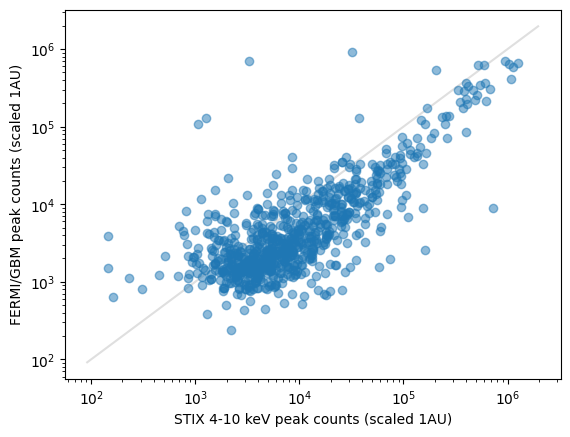

In [22]:
fig, ax = plt.subplots()
plt.scatter(test_compare["4-10 keV"]*test_compare["solo_position_AU_distance"]**2, test_compare["fermi_peak_counts"], alpha=0.5)
plt.yscale("log")
plt.xscale("log")

lims = np.array([
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
])

ax.plot(lims, lims,  alpha=0.25, zorder=0, color='grey')
ax.set_xlabel("STIX 4-10 keV peak counts (scaled 1AU)")
ax.set_ylabel("FERMI/GBM peak counts (scaled 1AU)")


Text(0, 0.5, 'FERMI/GBM peak counts (scaled 1AU)')

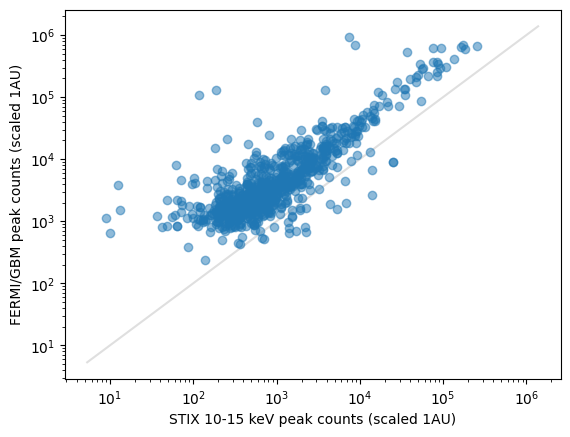

In [24]:
fig, ax = plt.subplots()
plt.scatter(test_compare["10-15 keV"]*test_compare["solo_position_AU_distance"]**2, test_compare["fermi_peak_counts"], alpha=0.5)
plt.yscale("log")
plt.xscale("log")
lims = np.array([
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
])

ax.plot(lims, lims,  alpha=0.25, zorder=0, color='grey')
ax.set_xlabel("STIX 10-15 keV peak counts (scaled 1AU)")
ax.set_ylabel("FERMI/GBM peak counts (scaled 1AU)")

[4.68144940e+00 1.38368339e+06]


Text(0, 0.5, 'FERMI/GBM peak counts (scaled 1AU)')

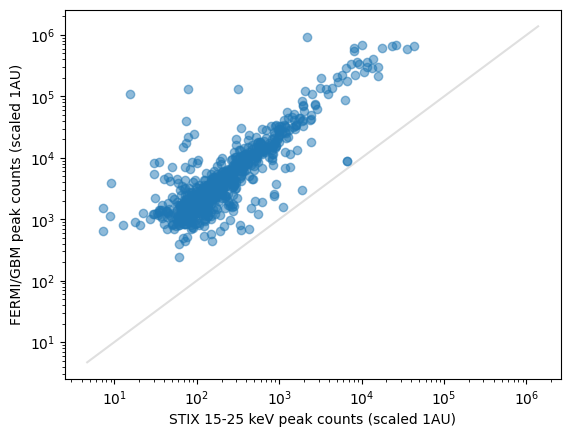

In [26]:
fig, ax = plt.subplots()
plt.scatter(test_compare["15-25 keV"]*test_compare["solo_position_AU_distance"]**2, test_compare["fermi_peak_counts"], alpha=0.5)
plt.yscale("log")
plt.xscale("log")
lims = np.array([
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
])

ax.plot(lims, lims,  alpha=0.25, zorder=0, color='grey')
print(lims)
ax.set_xlabel("STIX 15-25 keV peak counts (scaled 1AU)")
ax.set_ylabel("FERMI/GBM peak counts (scaled 1AU)")

In [27]:
print(scipy.stats.pearsonr(test_compare["4-10 keV"]*test_compare["solo_position_AU_distance"]**2, test_compare["fermi_peak_counts"]))
print(scipy.stats.pearsonr(test_compare["10-15 keV"]*test_compare["solo_position_AU_distance"]**2, test_compare["fermi_peak_counts"]))
print(scipy.stats.pearsonr(test_compare["15-25 keV"]*test_compare["solo_position_AU_distance"]**2, test_compare["fermi_peak_counts"]))
print(scipy.stats.pearsonr(test_compare["25-50 keV"]*test_compare["solo_position_AU_distance"]**2, test_compare["fermi_peak_counts"]))

PearsonRResult(statistic=0.7772236227327739, pvalue=2.568671321781024e-162)
PearsonRResult(statistic=0.8094607587869529, pvalue=3.028575743929677e-186)
PearsonRResult(statistic=0.817422844728029, pvalue=7.207641984552091e-193)
PearsonRResult(statistic=0.5165055087249641, pvalue=1.2604539484672688e-55)


In [28]:
print(scipy.stats.spearmanr(test_compare["4-10 keV"]*test_compare["solo_position_AU_distance"]**2, test_compare["fermi_peak_counts"]))
print(scipy.stats.spearmanr(test_compare["10-15 keV"]*test_compare["solo_position_AU_distance"]**2, test_compare["fermi_peak_counts"]))
print(scipy.stats.spearmanr(test_compare["15-25 keV"]*test_compare["solo_position_AU_distance"]**2, test_compare["fermi_peak_counts"]))


SignificanceResult(statistic=0.6639990206243278, pvalue=1.3519134381268506e-102)
SignificanceResult(statistic=0.7551013879316789, pvalue=4.185707612655493e-148)
SignificanceResult(statistic=0.8002709069301362, pvalue=5.596595918297112e-179)


In [29]:
test_compare.loc[:, "stix_peak_counts"] = test_compare["4-10 keV"] + test_compare["10-15 keV"]  + test_compare["15-25 keV"] + test_compare["25-50 keV"] + test_compare["50-84 keV"]

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_57888/1347538976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_compare.loc[:, "stix_peak_counts"] = test_compare["4-10 keV"] + test_compare["10-15 keV"]  + test_compare["15-25 keV"] + test_compare["25-50 keV"] + test_compare["50-84 keV"]


In [30]:
test_compare.loc[:, "stix_peak_counts_2"] = test_compare["15-25 keV"] 

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_57888/635738692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_compare.loc[:, "stix_peak_counts_2"] = test_compare["15-25 keV"]


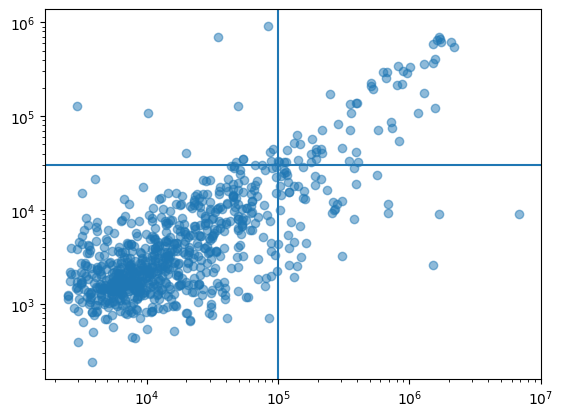

In [31]:
plt.scatter(test_compare["stix_peak_counts"], test_compare["fermi_peak_counts"], alpha=0.5)
plt.yscale("log")
plt.xscale("log")

plt.axhline(3e4)
plt.axvline(1e5)

In [32]:
test_compare[(test_compare["stix_peak_counts"]>5e5)&(test_compare["fermi_peak_counts"]<=3e4)][["start_UTC", 
                                                                                               'fermi_peak_counts', 'stix_peak_counts', 'att_in']]

,start_UTC,fermi_peak_counts,stix_peak_counts,att_in
805,2022-03-15T12:29:51.872,11473,687435,False
808,2022-03-15T22:37:07.745,9245,681691,False
870,2022-03-29T00:55:44.341,23640,564427,False
934,2022-03-30T17:18:23.999,9031,1671483,True
935,2022-03-30T17:18:15.999,9031,6774080,True
969,2022-03-31T18:36:24.160,2608,1504091,True


(-1200.0, 1200.0)

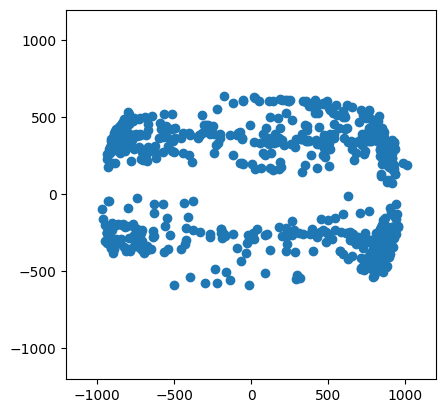

In [33]:
fig, ax = plt.subplots()
plt.scatter(test_compare["hpc_x_earth"], test_compare["hpc_y_earth"])
ax.set_box_aspect(1)
ax.set_xlim(-1200, 1200)
ax.set_ylim(-1200, 1200)

In [34]:
np.where((test_compare["stix_peak_counts"]<1e5)&(test_compare["fermi_peak_counts"]>=3e4))

(array([263, 278, 333, 398, 541, 542, 610, 638, 639, 659, 661, 669, 738]),)

In [35]:
test_compare[(test_compare["stix_peak_counts"]<1e5)&(test_compare["fermi_peak_counts"]>=5e4)][["start_UTC", 
                                                                                               'fermi_peak_counts', 'stix_peak_counts', 'att_in']]

,start_UTC,fermi_peak_counts,stix_peak_counts,att_in
1567,2022-10-03T02:24:04.562,107415,10175,False
2580,2023-01-25T09:45:37.532,129900,2911,False
2581,2023-01-25T09:48:21.532,129900,49051,False
2800,2023-02-17T20:05:32.263,693547,35099,True
3077,2023-03-03T17:47:30.781,916296,84203,False


[1.59593833e+02 2.38598691e+06]


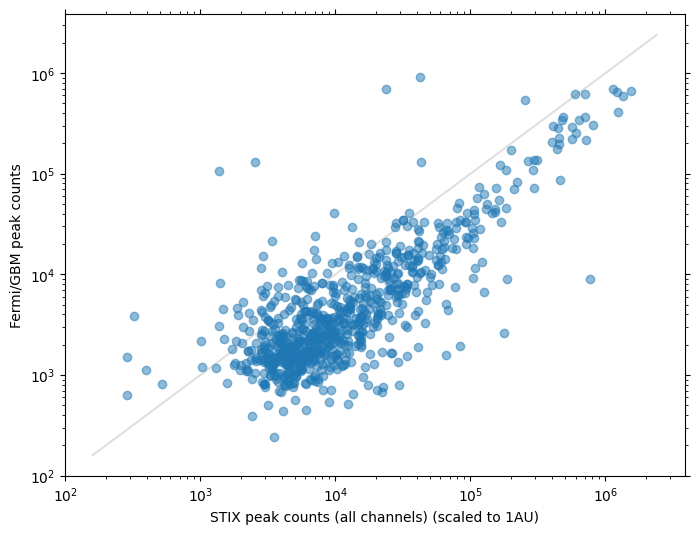

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(test_compare["stix_peak_counts"]*test_compare["solo_position_AU_distance"]**2, test_compare["fermi_peak_counts"], alpha=0.5)
plt.yscale("log")
plt.xscale("log")
ax.set_xlabel("STIX peak counts (all channels) (scaled to 1AU)")
ax.set_ylabel("Fermi/GBM peak counts")
ax.tick_params(which="both", right=True, top=True)
# ax.set_xlim(2e2, 3e6)
# ax.set_ylim(2e2, 3e6)
lims = np.array([
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
])

ax.plot(lims, lims,  alpha=0.25, zorder=0, color='grey')
print(lims)
